In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getNormalized(filepath):
    data = np.loadtxt(filepath, skiprows=8)
    return (data[1:, 0], data[1:,1]/data[0, 1])
def combineRandT(file1, file2):
    data1 = np.loadtxt(file1, skiprows=8)
    data2 = np.loadtxt(file2, skiprows=8)
    return (data1[1:, 0], data1[1:,1]/data1[0, 1] + data2[1:,1]/data2[0, 1]) #Assuming measured @ the same theta_1
def Rp(t1, t2):
    return np.tan(t1-t2)**2/np.tan(t1+t2)**2
def Tp(t1, t2):
    return 1-Rp(t1, t2)
def Rs(t1, t2):
    return np.sin(t1-t2)**2/(np.sin(t1+t2))**2
def Ts(t1, t2):
    return 1-Rs(t1, t2)

<ErrorbarContainer object of 3 artists>

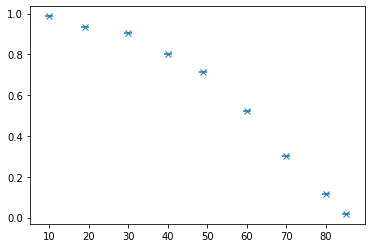

In [3]:
plt.errorbar(*getNormalized("data/a-g s trans.txt"), xerr=1, fmt='x')

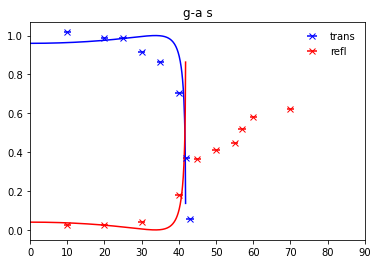

In [7]:
n_1 = 1.5 # approx 1 for air
n_2 = 1 #to be found later

theta_1s = np.linspace(0, np.pi/2, 1000)
theta_2s = np.arcsin(n_1*np.sin(theta_1s)/n_2)
plt.plot(theta_1s*180/np.pi, Tp(theta_1s, theta_2s), 'b')
plt.plot(theta_1s*180/np.pi, Rp(theta_1s, theta_2s), 'r')
plt.errorbar(*getNormalized("data/g-a s trans.txt"), xerr=0.5, fmt='bx', label="trans")
plt.errorbar(*getNormalized("data/g-a s refl.txt"), xerr=0.5, fmt='rx', label="refl")
plt.title("g-a s")
plt.legend(frameon=False)
plt.xlim(0, 90)
# plt.savefig("g-a s.png", dpi=200)